Importing the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import qiskit as qk

from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library.standard_gates import *

from ibm_quantum_widgets import *
from matplotlib import style

provider = IBMQ.load_account()

style.use("dark_background")

sim = Aer.get_backend('aer_simulator')

ibmqfactory.load_account:WARNING:2023-01-12 01:00:26,704: Credentials are already in use. The existing account in the session will be replaced.


Implementing the Euclidian algorithm to use in the classical part of the problem

In [ ]:
# finds the gcd of m and n
def euclidian( m, n ):

    # simplest case
    if not m:
        return 0, 1, n

    # recursion
    a, b, result = euclidian( n % m, m )

    # returning the updated values
    return b - n // m * a, a, result

Defining some variables for future use

In [ ]:
qubits = 8
r = range( qubits )
x = 7
K = 4
f = -1

Implementing a function for the modulo 15 circuit

In [ ]:
def x_mod_15( x, y ):
    K = 4
    circ = QuantumCircuit(K)

    for i in range(y):

        if x == 2 or x == 13:
            for m, n in ( (2,3), (1,2), (0,1) ):
                circ.swap( m, n )

        if x == 7 or x == 8:
            for m, n in ( (0,1), (1,2), (2,3) ):
                circ.swap( m, n )

        if x == 4 or x == 11:
            for m, n in ( (1,3), (0,2) ):
                circ.swap( m, n )

        if x == 7 or x == 11 or x == 13:
            for k in range(K):
                circ.x(k)

    circ = circ.to_gate()
    circ.name = "%i to the %i (mod %i)" % ( x, y, 15 )
    return circ.control()

Implementing a function for the Inverse Quantum Transform gate

In [ ]:
def iqft( qubits ):

    circ = QuantumCircuit( qubits )

    for q in range( qubits // 2 ):
        circ.swap( q, qubits - 1 - q )

    for i in r:
        for j in range( i ):
            circ.cp( -np.pi / ( 2**( i - j ) * 1.0 ), j, i )
        circ.h(i)

    circ.name = "IQFT"
    return circ

Constructing the circuit

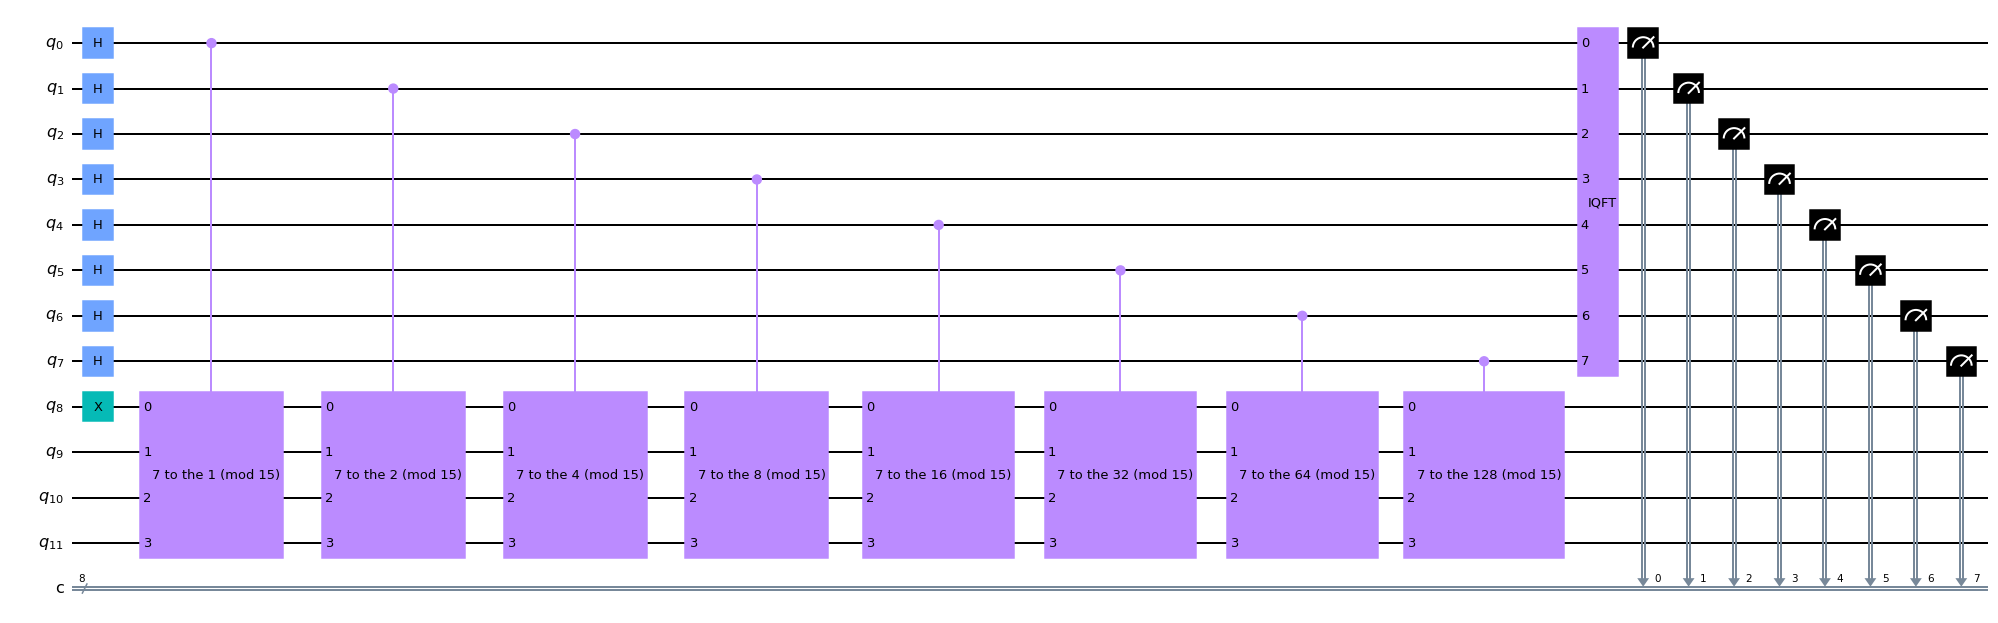

In [ ]:
circ = QuantumCircuit( qubits + K, qubits )

for i in r:
    circ.h(i)

circ.x( qubits )

for i in r:
    circ.append( x_mod_15( x, 2**i ), [i] + [ qubits + k for k in [0,1,2,3] ] )

circ.append( iqft( qubits ), r )
circ.measure( r, r )
circ.draw( fold = f )

Plotting results

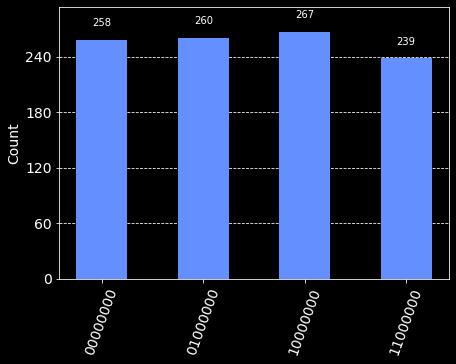

In [ ]:
C = aer_sim.run( assemble( transpile( circ, sim ) ) ).result().get_counts()
plot_histogram( C )

Factorizing a number

In [ ]:
a = 7
print( "gcd( 15, ", a, ") = ", euclidian( 15, a )[2] )
print( "15 and", a, "are indeed relatively prime." )

def phase_estimator(a):
    qubits = 8
    r = range( qubits )

    circ = QuantumCircuit( qubits + K, qubits )

    for i in r:
        circ.h(i)

    circ.x( qubits + K - 1 )

    for i in r:
        circ.append( x_mod_15(a, 2**i), [i] + [qubits + k for k in [0,1,2,3]] )

    circ.append( iqft(qubits), r )

    circ.measure( r, r )

    sim = Aer.get_backend('aer_simulator')
    mem = sim.run( assemble( transpile( circ, sim ), shots = 1 ), memory = True ).result().get_memory()
    return int( mem[0], 2 ) / ( 2**qubits )


denom = Fraction( phase_estimator(a) ).limit_denominator(15).denominator
factors = [ euclidian( a**(denom//2) - 1, 15 )[2], euclidian( a**(denom//2) + 1, 15)[2] ]

print( "\nWE GUESS THE FACTORS OF 15 TO BE:" , factors )

gcd( 15,  7 ) =  1
15 and 7 are indeed relatively prime.

WE GUESS THE FACTORS OF 15 TO BE: [3, 5]
